In [1]:
import pandas as pd
import os,sys
import unagi
from astropy.utils.data import download_file
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
dr_string = 'dr3'
re_string = 's20a_wide'
csv_file = f'Catalogues/hsc-{dr_string}-{re_string}-specz.csv'

bands = ['g','r','i','z','y']

# conditions that coadds must be at final data quality
if 'dud' in re_string:
    final_conditions = [
        'g_inputcount_value>=28',
        'r_inputcount_value>=28',
        'i_inputcount_value>=38',
        'z_inputcount_value>=63',
        'y_inputcount_value>=38',
    ]
else:
    final_conditions = [
        'g_inputcount_value>=4',
        'r_inputcount_value>=4',
        'i_inputcount_value>=6',
        'z_inputcount_value>=6',
        'y_inputcount_value>=6',
    ]

clean = True

if not os.access(csv_file,0):
    
    dr = unagi.hsc.Hsc(dr=dr_string, rerun=re_string)
    sql_cmd = [
        f'SELECT f.object_id, f2.i_sdsscentroid_ra, f2.i_sdsscentroid_dec, z.specz_redshift',
        f'FROM {re_string}.forced as f',
        f'LEFT JOIN {re_string}.forced2 as f2',
        f'ON f.object_id = f2.object_id',
        f'LEFT JOIN {re_string}.specz as z',
        f'ON f.object_id = z.object_id',
        f'WHERE z.specz_redshift>0.01 AND z.specz_redshift<3'
              ]
    sql_cmd = ' '.join(sql_cmd)
    if clean:
        sql_cmd += ' '+' '.join([f'AND {final_condition}' for final_condition in final_conditions])
    df = dr.sql_query(sql_cmd, from_file=False, verbose=True).to_pandas()
    df.to_csv(csv_file,index=False)
else:
    df = pd.read_csv(csv_file)

374760


<BarContainer object of 99 artists>

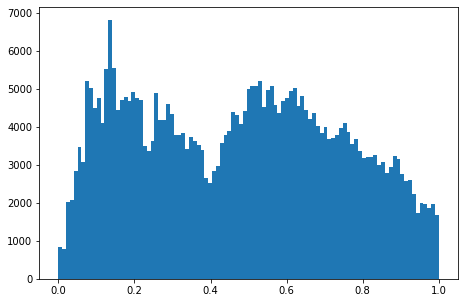

In [3]:
import matplotlib.pyplot as plt
import numpy as np
xmin,xmax=0.,1.
fig,ax = plt.subplots(figsize=(7.5,5))
xedges = np.linspace(0,1,100)
xwidths = xedges[1:]-xedges[:-1]
H,xedges = np.histogram(df['specz_redshift'],bins=xedges,density=False)
print(np.sum(H))
ax.bar(xedges[:-1],H,width=xwidths,align='edge')


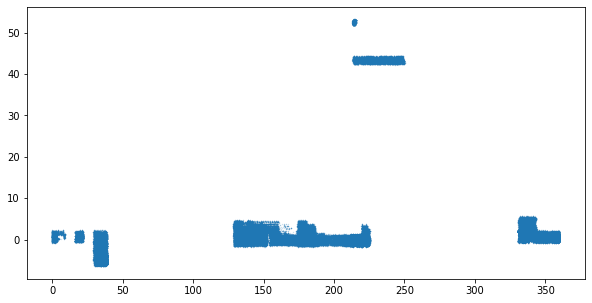

In [4]:
fig,ax=plt.subplots(figsize=(10,5))
ax.scatter(df.i_sdsscentroid_ra,df.i_sdsscentroid_dec,s=0.1,alpha=0.3)

In [5]:
import unagi
dr = unagi.hsc.Hsc(dr=dr_string, rerun=re_string)
dr.tables()

# Get table list from /home/connor.bottrell/.conda/envs/tf39_cpu/lib/python3.9/site-packages/unagi-0.1.3.dev13-py3.9.egg/unagi/data/s20a_wide/s20a_wide_tables.fits
# Read from saved file /home/connor.bottrell/.conda/envs/tf39_cpu/lib/python3.9/site-packages/unagi-0.1.3.dev13-py3.9.egg/unagi/data/s20a_wide/s20a_wide_tables.fits


['calibframe',
 'forced',
 'forced2',
 'forced3',
 'forced4',
 'forced5',
 'frame',
 'frame_hpx11',
 'mag_corr',
 'masks_test20200303',
 'meas',
 'meas2',
 'meas3',
 'meas4',
 'mosaic',
 'mosaic_hpx11',
 'mosaicframe',
 'patch_qa',
 'random',
 'random_masks_test20200303',
 'specz',
 'summary',
 'warped',
 'warped_hpx11']

In [38]:
import astropy.units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.io import fits

def load_src_cat(data_release,rerun,clean=True):
    '''Generate/load Source catalogue for data release / rerun.'''
    csv_file = f'Catalogues/hsc-{data_release}-{rerun}-specz.csv'
    if not os.access(csv_file,0):
        dr = unagi.hsc.Hsc(dr=data_release, rerun=rerun)
        sql_cmd = [
            f'SELECT f.object_id, f2.i_sdsscentroid_ra, f2.i_sdsscentroid_dec,',
            f'z.specz_redshift',
            f'FROM {rerun}.forced as f',
            f'LEFT JOIN {rerun}.forced2 as f2',
            f'ON f.object_id = f2.object_id',
            f'LEFT JOIN {rerun}.specz as z',
            f'ON f.object_id = z.object_id',
            f'WHERE z.specz_redshift>=0.0001'
                  ]
        sql_cmd = ' '.join(sql_cmd)
        if clean:
            sql_cmd += ' '+' '.join([f'AND {cnd}' for cnd in hsc_coadd_cnds(rerun)])
        df = dr.sql_query(sql_cmd, from_file=False, verbose=True).to_pandas()
        df.to_csv(csv_file,index=False)
    else:
        df = pd.read_csv(csv_file)
    return df  

df = load_src_cat('dr3','s20a_wide')

lowz_df = df.loc[df.specz_redshift<0.02]
galaxy = lowz_df.iloc[200]

coord_1 = SkyCoord(galaxy.i_sdsscentroid_ra, galaxy.i_sdsscentroid_dec, frame='icrs', unit='deg')
s_ang = 40. * u.arcsec

# if not os.access('Cutouts/test_g.fits',0):
cutout_list = unagi.task.hsc_cutout(coord_1, cutout_size=s_ang, filters='grizy', archive=dr, 
                         use_saved=False, output_dir='Cutouts', verbose=False, prefix='test',
                         save_output=True)
for cutout_test in cutout_list:
    cutout_test.close()
    
_filename = 'Cutouts/test_{}.fits'

hsc_scale = 0.168 # arcsec/pixel
# data = fits.getdata(_filename.format('i'))
fig,axarr = plt.subplots(1,5,figsize=(25,5))

for i,band in enumerate(['g','r','i','z','y']):
    
    ax = axarr[i]
    data = fits.getdata(_filename.format(band))
    header = fits.getheader(_filename.format(band))
    f0 = header['FLUXMAG0']
    bkg = header['BGMEAN']
    ax.imshow(-2.5*np.log10((data)/f0/hsc_scale**2),vmin=16,vmax=24,cmap='bone',origin='lower')

AttributeError: 'Series' object has no attribute 'i_sdsscentroid_ra'

In [1]:
def make_bottrell_rgb(rgb,stretch=99,q=5,scale_r=1.,scale_g=1.,scale_b=1.):
    '''Convert images in rgb format (x,y,images).'''
    # assume images are in mag/arcsec2
    rgb = 10**(0.4*(22.5-rgb))
    rgb_scaled = np.tanh(rgb/np.percentile(rgb,stretch)*q)
    rgb_scaled[...,0]*=scale_r
    rgb_scaled[...,1]*=scale_g
    rgb_scaled[...,2]*=scale_b
    return rgb_scaled

def hsc_calibrate(filename,pixelscale=0.168):
    data = fits.getdata(filename)
    hdr = fits.getheader(filename)
    f0 = header['FLUXMAG0']
    data = -2.5*np.log10(data/f0/pixelscale**2) # mag/arscec2
    data[np.isnan(data)]=99
    return data

data_g = hsc_calibrate('Cutouts/test_g.fits')
data_r = hsc_calibrate('Cutouts/test_r.fits')
data_i = hsc_calibrate('Cutouts/test_i.fits')

rgb = np.stack([data_i,data_r,data_g])
rgb = rgb.transpose((1,2,0))
print(rgb.shape)

fig,ax = plt.subplots(figsize=(10,10))
rgb_scaled = make_bottrell_rgb(rgb,scale_r=1.,scale_g=1.,scale_b=1.2,q=1.)
ax.imshow(rgb_scaled, origin='lower', interpolation='None',aspect='auto')





NameError: name 'fits' is not defined

In [80]:
import pandas as pd
import numpy as np
import os,sys
import astropy.units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.io import fits
import unagi
import tempfile

def hsc_coadd_cnds(rerun):
    '''Conditions that HSC coadds must be at final data quality.'''
    if 'dud' in rerun:
        cnds = [
            'g_inputcount_value>=28',
            'r_inputcount_value>=28',
            'i_inputcount_value>=38',
            'z_inputcount_value>=63',
            'y_inputcount_value>=38',
        ]
    else:
        cnds = [
            'g_inputcount_value>=4',
            'r_inputcount_value>=4',
            'i_inputcount_value>=6',
            'z_inputcount_value>=6',
            'y_inputcount_value>=6',
        ]
    return cnds
    
def load_src_cat(data_release,rerun,clean=True):
    '''Generate/load Source catalogue for data release / rerun.'''
    csv_file = f'Catalogues/hsc-{data_release}-{rerun}-specz.csv'
    if not os.access(csv_file,0):
        dr = unagi.hsc.Hsc(dr=data_release, rerun=rerun)
        sql_cmd = [
            f'SELECT f.object_id, f.ra, f.dec,',
            f'z.specz_redshift',
            f'FROM {rerun}.forced as f',
            f'LEFT JOIN {rerun}.forced2 as f2',
            f'ON f.object_id = f2.object_id',
            f'LEFT JOIN {rerun}.specz as z',
            f'ON f.object_id = z.object_id',
            f'WHERE z.specz_redshift>=0.0001'
                  ]
        sql_cmd = ' '.join(sql_cmd)
        if clean:
            sql_cmd += ' '+' '.join([f'AND {cnd}' for cnd in hsc_coadd_cnds(rerun)])
            sql_cmd += ' ORDER BY f.object_id'
        df = dr.sql_query(sql_cmd, from_file=False, verbose=True).to_pandas()
        df.to_csv(csv_file,index=False)
    else:
        df = pd.read_csv(csv_file)
    return df  

def cutout_radec(data_release,rerun,ra,dec,fov_arcsec=60.,
                 bands=['g','r','i','z','y'],out_dir='.',out_prefix='HSC_Cutout'):
    '''Extract square HSC cutout centered at (ra,dec) [degrees] with full-width fov_arscec [arcsec] in band(s).'''
    dr = unagi.hsc.Hsc(dr=data_release, rerun=rerun)
    if type(bands)!=list:
        bands = list(bands)
    ctr_coord = SkyCoord(ra, dec, frame='icrs', unit='deg')
    fov_arcsec *= u.arcsec
    cutouts = unagi.task.hsc_cutout(ctr_coord, cutout_size=fov_arcsec, filters=''.join(bands), archive=dr, 
                             use_saved=False, output_dir=out_dir, verbose=False, prefix=out_prefix,img_type='coadd',
                             save_output=True, variance=True, mask=True)
    if type(cutouts)!=list:
        cutouts.close()
    else:
        for cutout in cutouts:
            cutout.close()
    return
    
def make_bottrell_rgb(rgb,stretch=99,q=5,scale_r=1.,scale_g=1.,scale_b=1.):
    '''Convert images in rgb format (x,y,images).'''
    # assume images are in mag/arcsec2
    rgb = 10**(0.4*(22.5-rgb))
    rgb_scaled = np.tanh(rgb/np.percentile(rgb,stretch)*q)
    rgb_scaled[...,0]*=scale_r
    rgb_scaled[...,1]*=scale_g
    rgb_scaled[...,2]*=scale_b
    return rgb_scaled

def hsc_calibrate_msb(filename,pixelscale=0.168):
    '''Calibrate HSC image to magnitude surface brightness [AB mag/arcsec2].'''
    data = fits.getdata(filename)
    hdr = fits.getheader(filename)
    f0 = hdr['FLUXMAG0']
    data = -2.5*np.log10(data/f0/pixelscale**2) # mag/arscec2
    data[np.isnan(data)]=99
    return data   

def hsc_calibrate_nanomaggies(filename,pixelscale=0.168):
    '''Calibrate HSC image to linear AB nanomaggies.'''
    data = fits.getdata(filename)
    hdr = fits.getheader(filename)
    f0 = hdr['FLUXMAG0']
    data = data/f0*1e9 # nanomaggies
    return data   

def cb_plot(nrows=1,ncols=1,sharex=False,sharey=False,panelsize_x=5,panelsize_y=5):
    '''My plotting style.'''
    import matplotlib.pyplot as plt
    from matplotlib import rc
    rc('font',**{'family':'serif'})
    rc('text', usetex=True)
    fig,axarr = plt.subplots(nrows,ncols,figsize=(ncols*panelsize_x,nrows*panelsize_y),sharey=sharey,sharex=sharex)
    for ax in np.asarray([axarr]).flat:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for spine in ['top','bottom','left','right']:
            ax.spines[spine].set_linewidth(0.5)
            ax.spines[spine].set_color('black')
        fig.subplots_adjust(wspace=0,hspace=0)
    return fig,axarr

def rgb_plot(ax,out_dir,out_prefix,bands=['g','r','i'],scale_r=1.,scale_g=1.,scale_b=1.2,q=1.):
    '''Plot rgb colour image on ax from 3 bands ordered blue/green/red.'''
    data_b = hsc_calibrate_msb(f'{out_dir}/{out_prefix}_{bands[0]}.fits')
    data_g = hsc_calibrate_msb(f'{out_dir}/{out_prefix}_{bands[1]}.fits')
    data_r = hsc_calibrate_msb(f'{out_dir}/{out_prefix}_{bands[2]}.fits')
    rgb = np.stack([data_r,data_g,data_b])
    rgb = rgb.transpose((1,2,0))
    rgb_scaled = make_bottrell_rgb(rgb,scale_r=scale_r,scale_g=scale_g,scale_b=scale_b,q=q)
    ax.imshow(rgb_scaled, origin='lower', interpolation='None',aspect='auto')
    return


def main():
    
    data_release = 'dr3'
    rerun = 's20a_wide'
    df = load_src_cat(data_release,rerun)
    fig_dir = '/lustre/work/connor.bottrell/RealSim_HSC/Figures'
    bands = 'grizy'
    fov_arcsec = 40.
    
    # low-z sample
    lowz_df = df.loc[(df.specz_redshift<0.02) & (df.specz_redshift>0.01)]
    idxs = lowz_df.index
    for idx in idxs:
        galaxy = lowz_df.loc[idx]
        out_prefix = f'HSC_Cutout_{int(galaxy.object_id)}'
        fig_name = f'{fig_dir}/{out_prefix}.pdf'
        if os.access(fig_name,0): continue
        with tempfile.TemporaryDirectory() as out_dir:
            cutout_radec(data_release,rerun,galaxy.ra,galaxy.dec,
                         fov_arcsec=fov_arcsec,bands=bands,out_dir=out_dir,out_prefix=out_prefix)
            fig,axarr = cb_plot(2,3,sharey=True,panelsize_x=5,panelsize_y=5)
            axarr = axarr.flatten()
            for i,band in enumerate(['g','r','i','z','y']):
                filename = f'{out_dir}/{out_prefix}_{band}.fits'
                data = hsc_calibrate_msb(filename)
                ax = axarr[i]
                ax.imshow(data,vmin=16,vmax=26,cmap='bone',origin='lower',aspect='auto',interpolation='None')
            ax = axarr[5]
            rgb_plot(ax,out_dir,out_prefix,q=1)
            fig.savefig(fig_name,bbox_inches='tight')
        
if __name__=='__main__':
    main()

In [36]:
40000*0.5/60/24/4

3.472222222222222

In [59]:
190+189*3

757